


---





**WEB SCRAPPING PARA PENSUMS DE UNIVERSIDAD GALILEO**



---



# **0. Dependencias e Imports**

## 0.1. descargar librerias de Python

In [1]:
!pip install requests beautifulsoup4 selenium webdriver-manager
!apt-get update
!apt install chromium-chromedriver

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.0/512.0 kB 31.2 MB/s eta 0:00:00
Hit:1 https://cli.github.com/packages stable InRelease
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,159 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,840 kB]
Get:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,286 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports

## 0.2. imports necesarios

In [2]:
import requests
from bs4 import BeautifulSoup
import json
import time
import os
import re
from pathlib import Path
from google.colab import files
import shutil

## 0.3. Estructura en la WEB

Esta imagen refleja como es que se encuentran los datos en la pagina web, que estructura tienen y en general como se presenta la informacion, este paso es esencial para saber como tratar los datos.

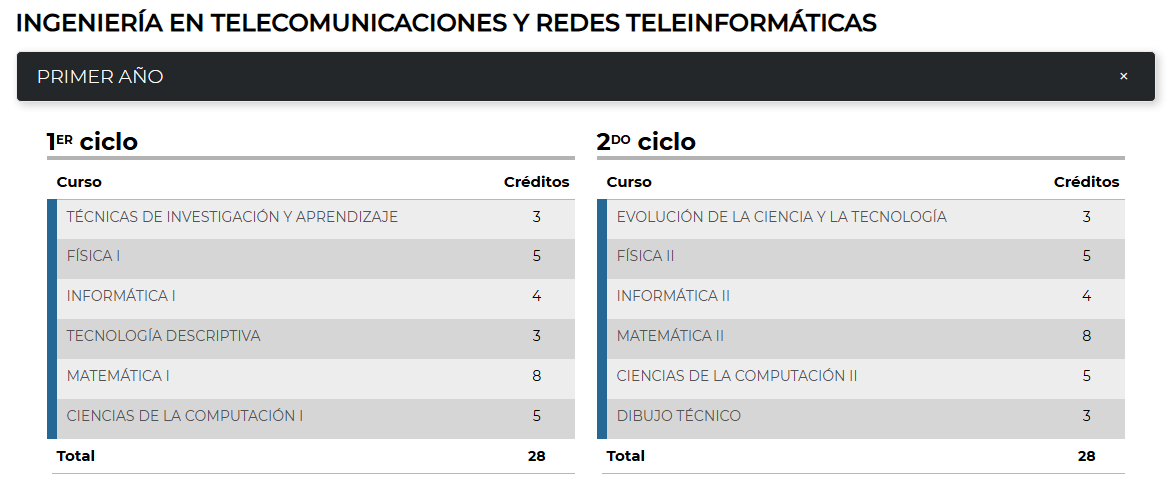

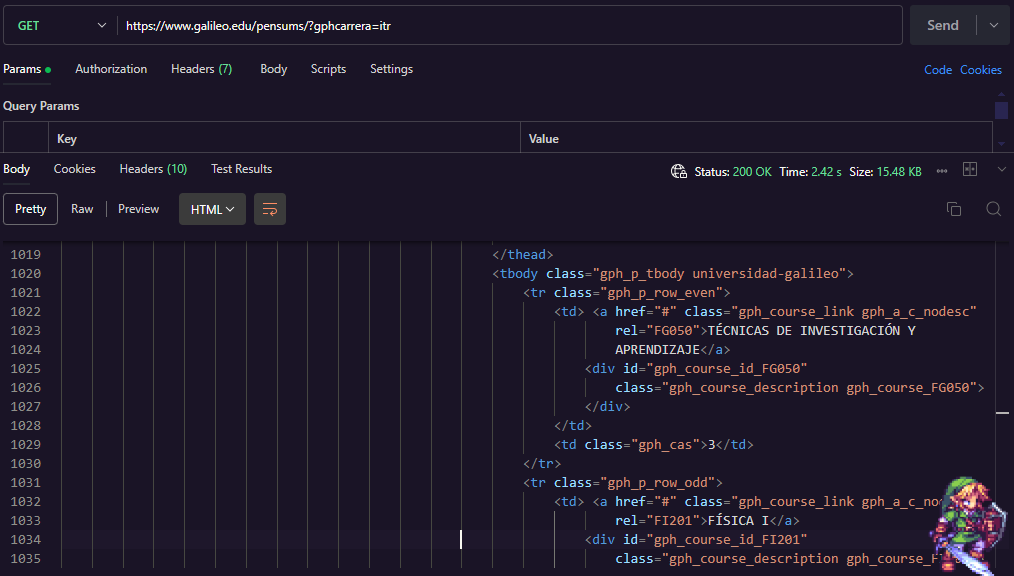

# 1. **metodos para Web Scrapping**

## 1.1. Funcion para limpiar textos

esta funcion es principalmente usada al momento de encontrar textos con formatos especiales por ser paginas web con HTML, tildes, o texto que pueda llegar a ser problematico al momento de construir a futuro la base de datos vectorial para el RAG

In [3]:
def limpiar_texto(texto):
    if not texto:
        return ""
    # Remover espacios extras y saltos de linea
    texto = re.sub(r'\s+', ' ', texto)
    # Remover caracteres especiales HTML
    texto = texto.replace('&ntilde;', 'ñ')
    texto = texto.replace('&aacute;', 'á')
    texto = texto.replace('&eacute;', 'é')
    texto = texto.replace('&iacute;', 'í')
    texto = texto.replace('&oacute;', 'ó')
    texto = texto.replace('&uacute;', 'ú')
    texto = texto.replace('&Ntilde;', 'Ñ')
    return texto.strip()

## 1.2. extraccion de texto por ciclo

Este metodo esta construido de tal manera que al obtener cada ciclo por el formato que se tiene el la pagina de la universidad, extraer la informacion de las tablas de cada ciclo y quedarmos con su informacion como tal

In [4]:
def procesar_ciclo(ciclo_html, nombre_ano, pensum_data, texto_completo_partes):
    # obtener titulo del ciclo
    titulo_ciclo_elem = ciclo_html.find('h3', class_='gph_p_cycle_title')
    if not titulo_ciclo_elem:
        return

    nombre_ciclo = limpiar_texto(titulo_ciclo_elem.get_text())
    nombre_ciclo_completo = f"{nombre_ano} - {nombre_ciclo}" if nombre_ano else nombre_ciclo
    print(f"    Ciclo: {nombre_ciclo}")

    # buscar tabla de materias
    tabla = ciclo_html.find('table', class_='gph_p_table')

    if not tabla:
        print(f"      ERROR:  No se encontró tabla en este ciclo")
        return

    # extraer materias
    materias = []
    tbody = tabla.find('tbody')

    if tbody:
        filas = tbody.find_all('tr')
        for fila in filas:
            celdas = fila.find_all('td')
            if len(celdas) >= 2:
                # primera celda: nombre del curso (dentro de un <a>)
                celda_curso = celdas[0]
                link_curso = celda_curso.find('a')
                if link_curso:
                    codigo_curso = link_curso.get('rel', [''])[0] if link_curso.get('rel') else ''
                    nombre_curso = limpiar_texto(link_curso.get_text())
                else:
                    codigo_curso = ''
                    nombre_curso = limpiar_texto(celda_curso.get_text())

                # segunda celda: creditos
                creditos_texto = limpiar_texto(celdas[1].get_text())

                # extraer número de créditos
                try:
                    creditos = int(re.sub(r'[^\d]', '', creditos_texto))
                except:
                    creditos = 0
                if nombre_curso and nombre_curso.lower() != 'curso':
                    materia = {
                        "codigo": codigo_curso,
                        "nombre": nombre_curso,
                        "creditos": creditos
                    }
                    materias.append(materia)
                    pensum_data["materias_totales"] += 1
                    pensum_data["creditos_totales"] += creditos

    # agregar ciclo con sus materias
    if materias:
        pensum_data["ciclos"].append({
            "nombre": nombre_ciclo_completo,
            "materias": materias,
            "total_creditos": sum(m["creditos"] for m in materias)
        })
        print(f"      resumen: {len(materias)} materias, {sum(m['creditos'] for m in materias)} créditos")

        # Construir texto
        texto_ciclo = f"\n{nombre_ciclo_completo}\n{'='*60}\n"
        for materia in materias:
            texto_ciclo += f"- {materia['nombre']} ({materia['codigo']}) - {materia['creditos']} créditos\n"
        texto_completo_partes.append(texto_ciclo)

## 1.3. Extraer pensum de una carrera de Galileo

este metodo su funcion principal es extraer la informacion del pensum de la universidad y utiliza BeatigulSoup



*   Args:URL del pensum (ej: https://www.galileo.edu/pensums/?gphcarrera=IE)
        titulo_carrera: Nombre de la carrera
*   Returns: dict con información del pensum extraída

In [5]:
def extraer_pensum_galileo(url, titulo_carrera):
    print(f"\n{'='*70}")
    print(f"Extrayendo: {titulo_carrera}")
    print(f"URL: {url}")
    print(f"{'='*70}")

    # Headers para la peticion
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36',
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
        'Accept-Language': 'es-GT,es;q=0.9,en;q=0.8',
        'Accept-Encoding': 'gzip, deflate, br',
        'Connection': 'keep-alive',
    }

    pensum_data = {
        "carrera": titulo_carrera,
        "universidad": "Galileo",
        "url": url,
        "ciclos": [],
        "materias_totales": 0,
        "creditos_totales": 0,
        "texto_completo": ""
    }

    try:
        # hacer request
        print("...Descargando pagina...")
        response = requests.get(url, headers=headers, timeout=15)
        response.raise_for_status()
        response.encoding = 'utf-8'

        print(f" Respuesta recibida: {response.status_code}")

        # parsear HTML
        soup = BeautifulSoup(response.text, 'html.parser')

        # Extraer titulo de la carrera desde el HTML si esta disponible
        titulo_html = soup.find('h1', class_='gph_title')
        if titulo_html:
            titulo_extraido = limpiar_texto(titulo_html.get_text())
            if titulo_extraido:
                pensum_data["carrera"] = titulo_extraido
                print(f" Carrera detectada: {titulo_extraido}")

        # Buscar estructura de acordeon (flat-toggle)
        acordeones = soup.find_all('div', class_='flat-toggle')

        texto_completo_partes = []

        if acordeones:
            # tiene estructura de acordeones
            print(f" Encontrados {len(acordeones)} bloques de contenido (acordeones)")

            # procesar cada acordeon (año academico en la pagina)
            for acordeon_idx, acordeon in enumerate(acordeones, 1):
                # obtener titulo del año
                titulo_ano = acordeon.find('div', class_='toggle-title')
                nombre_ano = limpiar_texto(titulo_ano.get_text()) if titulo_ano else f"Año {acordeon_idx}"

                print(f"\n   Procesando: {nombre_ano}")

                # buscar todos los ciclos (gph_p_cycle_left y gph_p_cycle_right)
                ciclos_html = acordeon.find_all('li', class_=lambda x: x and ('gph_p_cycle' in x))

                for ciclo_html in ciclos_html:
                    procesar_ciclo(ciclo_html, nombre_ano, pensum_data, texto_completo_partes)

        else:
            # no tiene acordeones, buscar directamente todas las tablas
            print(" sin acordeones, buscando tablas directamente")

            # buscar contenedor principal de pensum
            contenedor_pensum = soup.find('div', class_='gph_pensum') or soup.find('div', class_='gph_p_container') or soup

            # buscar todos los ciclos directamente
            ciclos_html = contenedor_pensum.find_all('li', class_=lambda x: x and ('gph_p_cycle' in str(x)))

            if not ciclos_html:
                # buscar todos los <li> que contengan tablas
                todos_li = contenedor_pensum.find_all('li')
                ciclos_html = [li for li in todos_li if li.find('table', class_='gph_p_table')]

            print(f" encontrados {len(ciclos_html)} ciclos")

            for ciclo_html in ciclos_html:
                # determinar nombre del año por la posicion
                nombre_ano = "Pensum"
                procesar_ciclo(ciclo_html, nombre_ano, pensum_data, texto_completo_partes)

        # construir texto completo
        if texto_completo_partes:
            encabezado = f"UNIVERSIDAD GALILEO\n"
            encabezado += f"CARRERA: {pensum_data['carrera']}\n"
            encabezado += f"Total de materias: {pensum_data['materias_totales']}\n"
            encabezado += f"Total de créditos: {pensum_data['creditos_totales']}\n"
            encabezado += f"URL: {url}\n"
            encabezado += f"{'='*80}\n"

            pensum_data["texto_completo"] = encabezado + "\n".join(texto_completo_partes)
        else:
            # si no se extrajo nada, guardar el HTML completo como texto
            pensum_data["texto_completo"] = soup.get_text(separator='\n', strip=True)

        # Resumen
        print(f"\n Extracción completada:")
        print(f"   - Ciclos/Semestres: {len(pensum_data['ciclos'])}")
        print(f"   - Materias totales: {pensum_data['materias_totales']}")
        print(f"   - Créditos totales: {pensum_data['creditos_totales']}")
        print(f"   - Texto completo: {len(pensum_data['texto_completo'])} caracteres")

        return pensum_data

    except requests.exceptions.RequestException as e:
        print(f" Error de conexión: {str(e)}")
        pensum_data["error"] = f"Error de conexión: {str(e)}"
        return pensum_data

    except Exception as e:
        print(f" Error al extraer pensum: {str(e)}")
        import traceback
        pensum_data["error"] = str(e)
        pensum_data["error_traceback"] = traceback.format_exc()
        return pensum_data

## 1.4. Extraccion de varios pensums a la vez

Extrae múltiples pensums de Galileo

* Args: lista_pensums: lista de dicts con 'titulo' y 'url', output_dir: directorio donde guardar los resultados
    
* Returns: lista de resultados de extraccion

In [6]:

def extraer_pensums_galileo(lista_pensums, output_dir="data/raw/galileo/pensums"):
    # crear directorio si no existe
    Path(output_dir).mkdir(parents=True, exist_ok=True)

    resultados = []

    print(f"INICIANDO EXTRACCIÓN DE {len(lista_pensums)} PENSUMS DE GALILEO")

    for i, pensum_info in enumerate(lista_pensums, 1):
        print(f"\n[{i}/{len(lista_pensums)}]")

        titulo = pensum_info["titulo"]
        url = pensum_info["url"]

        # extraer pensum
        resultado = extraer_pensum_galileo(url, titulo)
        resultados.append(resultado)

        # crear nombre de archivo seguro
        filename_base = titulo.lower()
        filename_base = filename_base.replace('ó', 'o').replace('í', 'i').replace('á', 'a').replace('é', 'e').replace('ú', 'u')
        filename_base = filename_base.replace('ñ', 'n')
        filename_base = re.sub(r'[^\w\s-]', '', filename_base)
        filename_base = re.sub(r'[-\s]+', '_', filename_base)

        # guardar JSON
        json_path = os.path.join(output_dir, f"{filename_base}.json")
        with open(json_path, 'w', encoding='utf-8') as f:
            json.dump(resultado, f, ensure_ascii=False, indent=2)
        print(f" Guardado JSON: {json_path}")

        # Guardar TXT
        txt_path = os.path.join(output_dir, f"{filename_base}.txt")
        with open(txt_path, 'w', encoding='utf-8') as f:
            f.write(resultado["texto_completo"])
        print(f" Guardado TXT: {txt_path}")

        # Pausa entre requests
        if i < len(lista_pensums):
            print("........................")
            time.sleep(2)

    # Resumen final
    print(f"\n{'='*80}")
    print(f" RESUMEN DE EXTRACCION")
    print(f"{'='*80}")

    exitosos = [r for r in resultados if not r.get('error')]
    con_error = [r for r in resultados if r.get('error')]

    print(f"Total procesados: {len(resultados)}")
    print(f" Exitosos: {len(exitosos)}")
    print(f" Con errores: {len(con_error)}")

    if con_error:
        print("\nCarreras con error:")
        for r in con_error:
            print(f"  - {r['carrera']}: {r.get('error', 'Error desconocido')[:100]}")

    if exitosos:
        print(f"\ Carreras procesadas exitosamente:")
        for r in exitosos:
            print(f"  - {r['carrera']}: {r['materias_totales']} materias, {r['creditos_totales']} créditos")

    print(f"\n Archivos guardados en: {output_dir}")

    return resultados


def extraer_carrera_individual(url, titulo):
    Path("data/raw/galileo/pensums").mkdir(parents=True, exist_ok=True)
    return extraer_pensum_galileo(url, titulo)


<>:61: SyntaxWarning: invalid escape sequence '\ '
<>:61: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipython-input-3491810656.py:61: SyntaxWarning: invalid escape sequence '\ '
  print(f"\ Carreras procesadas exitosamente:")


# **2. Extraer pensums**

## 2.1. Extracción de pensums

aqui se definen que enlaces se usaran para hacer web scrapping

In [7]:
pensums_galileo = [
    {
        "titulo": "Ingeniería en Sistemas",
        "url": "https://www.galileo.edu/pensums/?gphcarrera=ii"
    },
    {
        "titulo": "Ingeniería en Mecatrónica",
        "url": "https://www.galileo.edu/pensums/?gphcarrera=IME"
    },
    {
        "titulo": "Ingeniería en Electrónica",
        "url": "https://www.galileo.edu/pensums/?gphcarrera=IE"
    },
    {
        "titulo": "Ingeniería Industrial",
        "url": "https://www.galileo.edu/facti/carrera/iad/informacion-de-la-carrera/pensum/"
    },
    {
        "titulo": "Ingeniería Química",
        "url": "https://www.galileo.edu/pensums/?gphcarrera=INQ"
    },
    {
        "titulo": "Ingeniería en Telecomunicaciones",
        "url": "https://www.galileo.edu/pensums/?gphcarrera=itr"
    },
    {
        "titulo": "Ingeniería Administrativa",
        "url": "https://www.galileo.edu/facti/carrera/iad/informacion-de-la-carrera/pensum/"
    },
    {
        "titulo": "Licenciatura en Gerencia de Negocios y Servicios",
        "url": "https://www.galileo.edu/pensums/?gphcarrera=LGNS5"
    },
    {
        "titulo": "Licenciatura en Psicopedagogía",
        "url": "https://www.galileo.edu/faced/carrera/licenciatura-psicopedagogia/pensum/"
    },
    {
        "titulo": "Licenciatura en Comunicación y Diseño",
        "url": "https://www.galileo.edu/pensums/?gphcarrera=LCD"
    },
    {
        "titulo": "Licenciatura en Alimentación y Nutrición",
        "url": "https://www.galileo.edu/pensums/?gphcarrera=LAN"
    },
    {
        "titulo": "Licenciatura en Química Biológica",
        "url": "https://www.galileo.edu/facisa/carrera/lbc/pensum/"
    },
    {
        "titulo": "Licenciatura en Optometría",
        "url": "https://www.galileo.edu/facisa/carrera/lopt/pensum/"
    },
    {
        "titulo": "Licenciatura en Gestión Empresarial",
        "url": "https://www.galileo.edu/facisa/carrera/lge/pensum/"
    },
    {
        "titulo": "Licenciatura en Gestión Empresarial",
        "url": "https://www.galileo.edu/facisa/carrera/lge/pensum/"
    },
    {
        "titulo": "Licenciatura en Gestión Empresarial",
        "url": "https://www.galileo.edu/facisa/carrera/lge/pensum/"
    },
    {
        "titulo": "Licenciatura en Gastronomía y Administración Culinaria",
        "url": "https://www.galileo.edu/facisa/carrera/lgac/pensum/"
    },
    {
        "titulo": "Licenciatura en Fisioterapia",
        "url": "https://www.galileo.edu/facisa/carrera/lf/pensum/"
    },
    {
        "titulo": "Licenciatura en Enfermería",
        "url": "https://www.galileo.edu/facisa/carrera/len/pensum-2/"
    },
    {
        "titulo": "Licenciatura en Administración y Microfinanzas",
        "url": "https://www.galileo.edu/esec/carrera/licenciatura-administracion-microfinanzas/pensum/"
    },
    {
        "titulo": "Licenciatura en Diplomacia y Relaciones Internacionales",
        "url": "https://www.galileo.edu/pensums/?gphcarrera=LDRI"
    },
    {
        "titulo": "Licenciatura en Medios de Comunicación e Informativos",
        "url": "https://www.galileo.edu/esip/carrera/licenciatura-medios-comunicacion-informativos-pensum/"
    },
    {
        "titulo": "Licenciatura en Música",
        "url": "https://www.galileo.edu/esa/carrera/licenciatura-musica/pensum/"
    },
    {
        "titulo": "Licenciatura en Arte",
        "url": "https://www.galileo.edu/esa/carrera/licenciatura-arte/pensum/"
    },
    {
        "titulo": "Licenciatura en Mercadotecnia",
        "url": "https://www.galileo.edu/pensums/?gphcarrera=LMER"
    },
    {
        "titulo": "Licenciatura en Administracion de Empresas",
        "url": "https://www.galileo.edu/pensums/?gphcarrera=LADMOS"
    }


]

resultados = extraer_pensums_galileo(pensums_galileo)

# verificar resultados
for r in resultados:
    if not r.get('error'):
        print(f" {r['carrera']}: {r['materias_totales']} materias, {r['creditos_totales']} créditos")
    else:
        print(f" {r['carrera']}: {r.get('error', 'ERROR')[:80]}")

INICIANDO EXTRACCIÓN DE 26 PENSUMS DE GALILEO

[1/26]

Extrayendo: Ingeniería en Sistemas
URL: https://www.galileo.edu/pensums/?gphcarrera=ii
...Descargando pagina...
 Respuesta recibida: 200
 Carrera detectada: INGENIERÍA DE SISTEMAS INFORMÁTICA Y CIENCIAS DE LA COMPUTACIÓN
 Encontrados 4 bloques de contenido (acordeones)

   Procesando: primer año
    Ciclo: 1er ciclo
      resumen: 6 materias, 28 créditos
    Ciclo: 2do ciclo
      resumen: 6 materias, 28 créditos

   Procesando: segundo año
    Ciclo: 3er ciclo
      resumen: 6 materias, 31 créditos
    Ciclo: 4to ciclo
      resumen: 6 materias, 28 créditos

   Procesando: tercer año
    Ciclo: 5to ciclo
      resumen: 6 materias, 28 créditos
    Ciclo: 6to ciclo
      resumen: 6 materias, 28 créditos

   Procesando: cuarto año
    Ciclo: 7mo ciclo
      resumen: 6 materias, 28 créditos
    Ciclo: 8vo ciclo
      resumen: 6 materias, 28 créditos

 Extracción completada:
   - Ciclos/Semestres: 8
   - Materias totales: 48
   - Crédi

## 2.2. Descargar Archivos

descarga de los archivos obtenidos con la informacion capturada de la universidad

In [8]:
shutil.make_archive('galileo_pensums', 'zip', 'data/raw/galileo/pensums')
files.download('galileo_pensums.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>